<a href="https://colab.research.google.com/github/NganTran-0017/LING5412/blob/main/GPT_LING5412_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 123 kB 9.2 MB/s 
     |████████████████████████████████| 90 kB 7.9 MB/s 
     |████████████████████████████████| 131 kB 54.8 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 8.4 MB 59.6 MB/s 
     |████████████████████████████████| 138 kB 74.7 MB/s 
     |████████████████████████████████| 127 kB 49.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

In [ ]:
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

In [ ]:
import gensim
import gensim.downloader as api
nlp = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip" -d "/content/drive/MyDrive/"

# Unzip the dataset
#!unzip "/content/dontpatronizeme_v1.3.zip" -d "/content/drive/MyDrive/"

Mounted at /content/drive
unzip:  cannot find or open /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip, /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.zip or /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.ZIP.


In [ ]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)


In [ ]:
df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# Exploring data

In [ ]:
# Length of text
def length (txt):
  length = len(txt.split())
  return length

txt_length = df['paragraph'].apply(lambda x: length(x))
txt_length.sort_values(ascending = False)

3534    1519
6266    1095
8519    1040
4613     772
8819     729
        ... 
1930       4
1385       3
7375       3
5112       3
5742       0
Name: paragraph, Length: 10058, dtype: int64

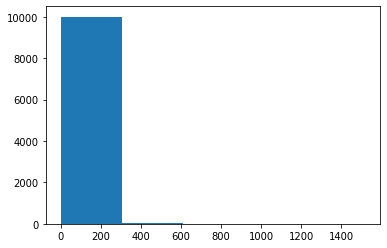

In [ ]:
# Plot the histogram of sentence length
plt.hist(txt_length, 5)
plt.show()

In [ ]:
# Observing labels
df['label'].value_counts()

0    8206
1     906
3     435
4     369
2     142
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].astype(str)
df['label']

0        0
1        0
2        4
3        0
4        0
        ..
10053    4
10054    0
10055    0
10056    0
10057    0
Name: label, Length: 10058, dtype: object

In [ ]:
# Missing data
#checking missing values
print('Is null: \n', df.isnull().sum() )


Is null: 
 docID        0
keyword      0
country      0
paragraph    0
label        0
dtype: int64


0    9112
1     946
Name: label, dtype: int64


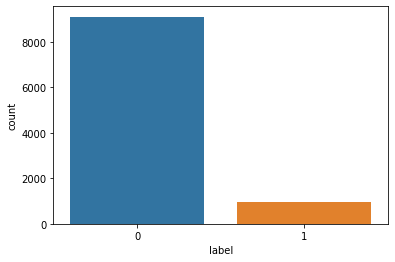

In [ ]:
# Turning labels to binary

label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Developing models

In [ ]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['paragraph']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (8046,) (8046,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    7289
1     757
Name: label, dtype: int64


## **Classic ML models**

### Text representation

In [ ]:
!pip install stop-words
from stop_words import get_stop_words
stopwords = get_stop_words('en')
from textblob import Word
import re
import nltk
nltk.download('wordnet')

#BOW based approaches
nlp.init_sims(replace=True) # calling for using syn0norm

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=c04f11ece912d1184f787265d9b20fefee04cdaba514b6aa1bad3c09a964d903
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Tokenize, and apply word vector averaging to tokenized text
import nltk
nltk.download('punkt')
import logging
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    

X_train_tokenized = X_train.apply(lambda x: w2v_tokenize_text(x)).values
X_test_tokenized = X_test.apply(lambda x: w2v_tokenize_text(x)).values

X_train_word_average = word_averaging_list(nlp,X_train_tokenized)
X_test_word_average = word_averaging_list(nlp,X_test_tokenized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).


### Creating models

In [ ]:
# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'weighted', zero_division=1)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
  print('F1 score: {}'.format(f1_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))
  print('\n', classification_report(y_true, y_pred))

# Get the measurements of ROC curve for each model
def get_roc_cuve (y_true, y_pred):
  #cmatrix = confusion_matrix(y_true, y_pred)

  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)
  #print('FPR:', FPR)
  
  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = { 'fpr': FPR, 'tpr': recall, 'auc': auc}
  return roc

In [ ]:
# Define a function for creating over sampling 
def score_model(model):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

    oversampler = SMOTE(random_state=42)
    #oversampler = RandomOverSampler(sampling_strategy='minority')
    scores = []
    f1_scores = []
    
    ## on training set, do cv
    for train_fold_index, val_fold_index in cv.split(X_train_word_average, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train_word_average[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_word_average[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = oversampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = accuracy_score(y_val_fold, model.predict(X_val_fold)) #  average= 'weighted' for F1
        f1 = sklearn.metrics.f1_score(y_val_fold, model.predict(X_val_fold),  average = 'macro', zero_division=1)  #f1_scores.append(f1_score)
        scores.append(score)
        f1_scores.append(f1)
        
    print('Average of acuracy score in training: %s' % np.array(scores).mean())
    print('Average of Macro F1-score in training: %s' % np.array(f1_scores).mean())

    ## on test set
    y_pred = model.predict(X_test_word_average)
    test_score = accuracy_score( y_test,y_pred)
    macro_f1_test = f1_score(y_test, y_pred,  average = 'macro', zero_division=1)
    printing_eval_scores (y_test, y_pred)
    roc = get_roc_cuve(y_test, y_pred)
    report_scores = {'accuracy_folds':np.array(scores),'accuracy_test':test_score, 'macro_f1_test': np.array(f1_scores), 'y_predicted':y_pred, 'roc': roc }
    return report_scores #(np.array(scores),test_score,y_pred )       #(np.array(scores).mean(), np.array(scores).std())

Average of acuracy score in training: 0.7895843643480578
Average of Macro F1-score in training: 0.6328994844641667
accuracy score: 0.794234592445328
precision score: 0.9020001923515237
recall score: 0.794234592445328
F1 score: 0.6387422020831454

Confusion Matrix:
 [[1459  364]
 [  50  139]]

               precision    recall  f1-score   support

           0       0.97      0.80      0.88      1823
           1       0.28      0.74      0.40       189

    accuracy                           0.79      2012
   macro avg       0.62      0.77      0.64      2012
weighted avg       0.90      0.79      0.83      2012

LR: 0.789584 (0.014373)
Average of acuracy score in training: 0.9015662673857069
Average of Macro F1-score in training: 0.6188729539703529
accuracy score: 0.8916500994035785
precision score: 0.8642576285967899
recall score: 0.8916500994035785
F1 score: 0.5843463691809667

Confusion Matrix:
 [[1762   61]
 [ 157   32]]

               precision    recall  f1-score   support

  

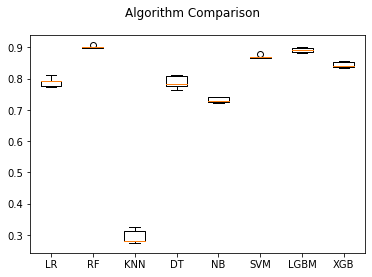

In [ ]:
# Running all models together
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=700)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(decision_function_shape='ovo', probability=True)))
models.append(('LGBM', LGBMClassifier(objective= 'binary')))
models.append(('XGB', XGBClassifier(eval_metric="mlogloss", objective = "reg:logistic") ))


# evaluate each model in turn
results = []
score_test = []
macro_f1 = []
names = []
rocs = {}
report_scores_all = []
for name, model in models:
  #fold_scores, test_score = score_model(model)
  report_scores = score_model(model)
  report_scores_all.append(report_scores)
  #results.append(fold_scores)
  #score_test.append(test_score)
  results.append(report_scores['accuracy_folds'])
  score_test.append(report_scores['accuracy_test'])
  macro_f1.append(report_scores['macro_f1_test'])
  rocs[name] = (report_scores['roc'])
  names.append(name)
  # msg = "%s: %f (%f)" % (name, fold_scores.mean(), fold_scores.std())
  msg = "%s: %f (%f)" % (name, report_scores['accuracy_folds'].mean(), report_scores['accuracy_folds'].std())
  print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithms Comparison in Terms of Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

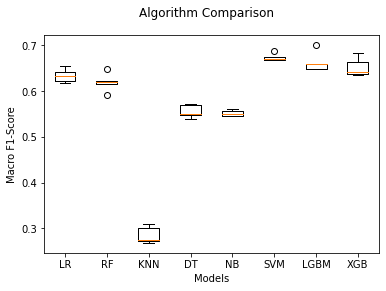

In [ ]:
# boxplot algorithm comparison in terms of Macro F1-Score
fig = plt.figure()
fig.suptitle('Algorithms Comparison in Terms of Macro F1-Score')
ax = fig.add_subplot(111)
plt.boxplot(macro_f1)
plt.ylabel('Macro F1-Score')
plt.xlabel('Models')
ax.set_xticklabels(names)
plt.show()

In [ ]:
rocs

{'DT': {'auc': 0.5940640899499923,
  'fpr': array([0.        , 0.15578716, 1.        ]),
  'tpr': array([0.        , 0.34391534, 1.        ])},
 'KNN': {'auc': 0.6083901470626649,
  'fpr': array([0.        , 0.73560066, 1.        ]),
  'tpr': array([0.        , 0.95238095, 1.        ])},
 'LGBM': {'auc': 0.6484499937599224,
  'fpr': array([0.        , 0.05759737, 1.        ]),
  'tpr': array([0.        , 0.35449735, 1.        ])},
 'LR': {'auc': 0.7678894316305177,
  'fpr': array([0.        , 0.19967087, 1.        ]),
  'tpr': array([0.        , 0.73544974, 1.        ])},
 'NB': {'auc': 0.6115754889753793,
  'fpr': array([0.        , 0.24245749, 1.        ]),
  'tpr': array([0.        , 0.46560847, 1.        ])},
 'RF': {'auc': 0.5679254209149985,
  'fpr': array([0.        , 0.03346133, 1.        ]),
  'tpr': array([0.        , 0.16931217, 1.        ])},
 'SVM': {'auc': 0.7276830156698506,
  'fpr': array([0.        , 0.09489852, 1.        ]),
  'tpr': array([0.        , 0.55026455, 1. 

# Pre-trained Models

## **BERT**

In [ ]:
# Required packages for BERT is moved to the top, in case restart is required

**Prepare training and testing data for BERT**

In [ ]:
len(X_train_word_average)

8046

In [ ]:
len(X_train_word_average[2])

300

In [ ]:
X_train_tokenized[0]

['She',
 'learns',
 'to',
 'read',
 'with',
 'encouragement',
 'from',
 'her',
 'new',
 'family',
 'and',
 'Max',
 'Jewish',
 'refugee',
 'who',
 'they',
 'are',
 'hiding',
 'under',
 'the',
 'stairs']

In [ ]:
# This func concatenate the tokenized words (which were already stripped of ,.?! and stopwords) together to create a sentence before tokenizing with BERT pretrained
def concat_words(words, labels):
  concat_words = []
  for i in range(words.shape[0]):
     concat_words.append( " ".join(words[i]) )
  concat_words = tuple(concat_words) 

  labels = tuple(labels.tolist())
  return concat_words, labels

train_texts, train_labels = concat_words(X_train_tokenized, y_train)
test_texts, test_labels   = concat_words(X_test_tokenized,  y_test) 

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(8046, 8046, 2012, 2012)

In [ ]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(X_train[302])
tokenizer.tokenize(train_texts[0]) 

100%|██████████| 231508/231508 [00:00<00:00, 919196.17B/s]


['she',
 'learns',
 'to',
 'read',
 'with',
 'encouragement',
 'from',
 'her',
 'new',
 'family',
 'and',
 'max',
 'jewish',
 'refugee',
 'who',
 'they',
 'are',
 'hiding',
 'under',
 'the',
 'stairs']

In [ ]:
# get max len in tokenized train text to set the tokens length in the next step
MAX_LEN = max(map(len, X_train_tokenized))  # can do len(max(X_train_tokenized, key=len)) also
print('MAX LEN of trainning sentence is:', MAX_LEN, '\nMAX LEN > 512 is ', MAX_LEN>512)

# Update MAX LEN if it's > 512, set it to be 225 
## 512 is is the maximum seq len of BERT_BASE. But we cannot allow the seq len to be 512 since we'll run out of GPU memory --> Use max len of 225
MAX_LEN = 225 if MAX_LEN > 512 else MAX_LEN

MAX LEN of trainning sentence is: 1349 
MAX LEN > 512 is  True




# Convert to tokens using tokenizer
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[: MAX_LEN] + ['[SEP]'], train_texts))
test_tokens  = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[: MAX_LEN] + ['[SEP]'], test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )
MAX_LEN

train_tokens[0]

# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen= MAX_LEN, truncating="post", padding="post", dtype="int")
test_tokens_ids  = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)),  maxlen= MAX_LEN, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

# Mask the paddings with 0 and words with 1
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

EPOCHS = 3
BATCH_SZ = 32

# Train BERT NLP
bert_clf.train_m(train_tokens_ids, y_train.to_numpy(),train_masks, EPOCHS, BATCH_SZ)

**Evaluate on Testing Set**

## Converting test token ids, test labels and test masks to a tensor and the create a tensor dataset out of them.
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1)).float()

# Convert to tensor for maks
test_masks_tensor = torch.tensor(test_masks)


# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Define test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

bert_clf.eval()     # Define eval
bert_predicted = [] # To Store predicted result
all_logits = []     # Predicted probabilities that is between 0 to 1 is stored here

with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

# Get ROC curve measurements
rocs['BERT'] = get_roc_cuve(y_test, bert_predicted)

# Prin performance
print('----------------------------BERT performance---------------------------')
printing_eval_scores(y_test, bert_predicted)

## **GPT-2**

In [ ]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# Load GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

     |████████████████████████████████| 3.1 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 18.2 MB/s 
     |████████████████████████████████| 3.3 MB 15.5 MB/s 
     |████████████████████████████████| 895 kB 17.4 MB/s 
     |████████████████████████████████| 61 kB 591 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

In [ ]:
# Padding sequences from the right to MAX_LEN (225)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(train_texts, return_tensors='pt', truncation=True, padding=True, max_length = MAX_LEN)
test_tokens  = tokenizer(test_texts,  return_tensors='pt', truncation=True, padding=True, max_length = MAX_LEN)

In [ ]:
# Convert List of words to list of numbers. (Words are replaced by their index in the dictionary)
train_tokens_ids = train_tokens.input_ids
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, test_tokens_ids.shape

(torch.Size([8046, 225]), torch.Size([2012, 225]))

In [ ]:
train_masks = train_tokens.attention_mask
test_masks = test_tokens.attention_mask

In [ ]:
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.cpu().detach().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))

In [ ]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 3
BATCH_SZ = 32
EPOCHS, BATCH_SZ

(3, 32)

In [ ]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids, y_train.to_numpy(), train_masks, EPOCHS, BATCH_SZ)

Epoch:  3
251/251.4375 loss: 0.18265043674332518 


**Evaluate on Testing Set**

In [ ]:
## Converting test token ids, test labels and test masks to a tensor and the create a tensor dataset out of them.
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor( y_test.to_numpy().reshape(-1, 1) ).long()

# Convert masks to tensor
test_masks_tensor = torch.tensor(test_masks)

# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Define test data loader
test_dataloader = DataLoader(test_dataset, sampler = test_sampler, batch_size=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [ ]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids, attention_mask=masks, labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

In [ ]:
rocs = {}
# Get ROC curve measurements
rocs['GPT'] = get_roc_cuve(y_test, gpt_predicted)

# Prin performance
print('----------------------------GPT performance---------------------------')
printing_eval_scores(y_test, gpt_predicted)

----------------------------GPT performance---------------------------
accuracy score: 0.8916500994035785
precision score: 0.9084980491685796
recall score: 0.8916500994035785
F1 score: 0.7240575771302028

Confusion Matrix:
 [[1681  142]
 [  76  113]]

               precision    recall  f1-score   support

           0       0.96      0.92      0.94      1823
           1       0.44      0.60      0.51       189

    accuracy                           0.89      2012
   macro avg       0.70      0.76      0.72      2012
weighted avg       0.91      0.89      0.90      2012



In [ ]:
rocs

{'GPT': {'auc': 0.7599950079379592,
  'fpr': array([0.        , 0.07789358, 1.        ]),
  'tpr': array([0.       , 0.5978836, 1.       ])}}

In [ ]:
for i in rocs:
  print(i)
  print(rocs[i])

GPT
{'fpr': array([0.        , 0.07789358, 1.        ]), 'tpr': array([0.       , 0.5978836, 1.       ]), 'auc': 0.7599950079379592}


In [ ]:
# Export performance to a txt file
txtfile = open('GPT_result.txt','w')
for i in rocs:
  txtfile.write(str(i) + '=' + str(rocs[i]))

txtfile.close()

#**Visualize all models with ROC curves**

In [ ]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'LGBM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'LGBM':'1--','LR': 'v--', 'SVM': '^--', 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(rocs)